In [57]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sesd
import statsmodels.api as sm
import os
import os.path as path
import sklearn.metrics
import pmdarima as pm
import mlflow

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from mlflow.pyfunc import PythonModel
from pmdarima.arima.utils import ndiffs
from datetime import timedelta
from sklearn.metrics import mean_absolute_error as mape
from sklearn.metrics import mean_squared_error as mse


%matplotlib inline

/Users/alenalapteva/anaconda3/envs/alapteva-time-series/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
sns.set(style="darkgrid")
plt.rcParams.update({'figure.figsize': (7, 5), 'figure.dpi': 120})

In [5]:
df = pd.read_csv('../data/preprocessed/knn_imputated_ts.csv',
                       sep=',',
                       parse_dates=['date'], index_col=0)
df.head()

,7101_105005,7101_105043,7101_105264,7101_105523,7101_105554,7101_105568,7101_107589,7101_109263,7101_109382,7101_109383,...,7175_119311,7175_119619,7175_121374,7175_124460,7175_125222,7175_125239,7175_127204,7175_127276,7175_129110,7175_129164
date,,,,,,,,,,,,,,,,,,,,,
2016-11-06,19.250000,23.0,17.000000,21.0,28.000000,15.0,18.000000,13.0,29.222222,17.0,...,14.0,18.0,19.0,15.0,28.0,42.0,15.0,29.0,34.0,17.0
2016-11-13,19.611111,23.0,17.000000,21.0,26.814815,18.5,17.777778,13.0,16.000000,17.0,...,14.0,18.0,19.0,15.0,28.0,42.0,15.0,29.0,34.0,17.0
2016-11-20,19.000000,23.0,17.000000,21.0,30.000000,18.0,18.000000,13.0,33.000000,17.0,...,14.0,18.0,19.0,15.0,28.0,42.0,15.0,29.0,34.0,17.0
2016-11-27,19.500000,23.0,17.000000,21.0,26.000000,21.0,18.000000,13.0,38.666667,17.0,...,14.0,18.0,19.0,15.0,28.0,42.0,15.0,29.0,34.0,17.0
2016-12-04,20.333333,23.0,16.333333,20.5,24.444444,20.0,17.333333,13.0,16.000000,17.0,...,14.0,18.0,19.0,15.0,28.0,42.0,15.0,29.0,34.0,17.0


In [6]:
control_dates = pd.Series(['2017-10-01', '2017-12-31', '2018-04-22', 
               '2018-08-05', '2018-10-28'])
control_dates = pd.to_datetime(control_dates)

In [7]:
# planning horizon
ph = 14

def data_select(index, date):
    return (date < index) & (index <= (date + timedelta(weeks=ph)))

In [8]:
# cvset is a CV set with looks like [(train1, test1), (train2, test2), ..., (train5, test5)]
cvset = []
for i, date in enumerate(control_dates):
    cvset.append((df[df.index <= date], df[data_select(df.index, date)]))

In [112]:
metric_columns=['mape1', 'rmse1', 'mape2', 'rmse2', 'mape3', 'rmse3', 'mape4', 'rmse4', 'mape5', 'rmse5']

In [48]:
def calc_mean_metrics(df):
    last_index = df.index.max() + 1
    for col in df.columns:
        df.loc[last_index, col] = df[col].mean()
    mape_columns=['mape1', 'mape2', 'mape3', 'mape4', 'mape5']
    rmse_columns=['rmse1', 'rmse2', 'rmse3', 'rmse4', 'rmse5']
    mape_mean = df.loc[last_index, mape_columns].mean()
    rmse_mean = df.loc[last_index, rmse_columns].mean()
    return (mape_mean, rmse_mean)

In [63]:
class PythonModelWrapper(PythonModel):

    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        return self.model.predict(model_input)

/Users/alenalapteva/anaconda3/envs/alapteva-time-series/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
with mlflow.start_run(run_name='Mean'):
    metrics_mean = pd.DataFrame()
    mean = np.array
    for i in range(len(cvset)):
        for j, col in enumerate(cvset[i][0].columns):
            mean = np.full((ph, 1), cvset[i][0][col].mean())
            metrics_mean.loc[j, 'mape' + str(i+1)] = mape(mean, cvset[i][1][col])
            metrics_mean.loc[j, 'rmse' + str(i+1)] = mse(mean, cvset[i][1][col], squared=False)
    mape_mean, rmse_mean = calc_mean_metrics(metrics_mean)
    mlflow.log_metric("mape", mape_mean)
    mlflow.log_metric("rmse", rmse_mean)

In [9]:
random10ts = df.sample(10, axis=1, random_state=1)
random10ts_columns = random10ts.columns
collocs = []
for col in random10ts:
    collocs.append(df.columns.get_loc(col))
collocs

[192, 256, 169, 67, 201, 102, 112, 173, 90, 269]

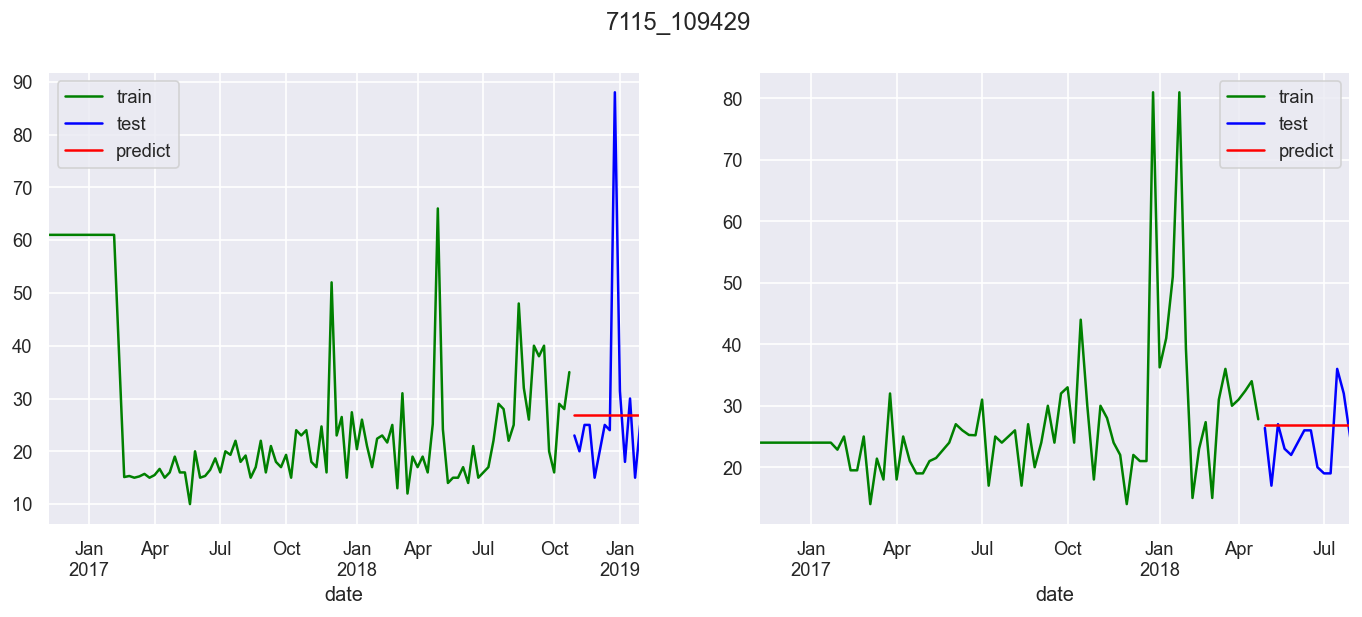

In [145]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))
#for i in range(len(collocs)):
cvset[4][0][random10ts_columns[0]].plot(subplots=True, title=columns4ts[0], ax=axes[0], color='green')
cvset[4][1][random10ts_columns[0]].plot(subplots=True, ax=axes[0], color='blue')
arr = np.array([cvset[4][0][random10ts_columns[0]].mean() for i in range(ph)])
pd.DataFrame(data=arr, index=cvset[4][1].index).plot(subplots=True, title=random10ts_columns[0], ax=axes[0], color='red')
axes[0].legend(['train', 'test', 'predict'])

cvset[2][0][random10ts_columns[1]].plot(subplots=True, ax=axes[1], color='green')
cvset[2][1][random10ts_columns[1]].plot(subplots=True,  ax=axes[1], label='test', color='blue')
arr = np.array([cvset[2][0][random10ts_columns[1]].mean() for i in range(ph)])
pd.DataFrame(data=arr, index=cvset[2][1].index).plot(subplots=True, title=random10ts_columns[1], ax=axes[1], color='red')
axes[1].legend(['train', 'test', 'predict'])

In [62]:
with mlflow.start_run(run_name='Mean4last'):
    metrics_mean4last = pd.DataFrame()
    mean = np.array
    for i in range(len(cvset)):
        for j, col in enumerate(cvset[i][0].columns):
            mean = np.full((ph, 1), cvset[i][0][col].iloc[-4:].mean())
            metrics_mean4last.loc[j, 'mape' + str(i+1)] = mape(mean, cvset[i][1][col])
            metrics_mean4last.loc[j, 'rmse' + str(i+1)] = mse(mean, cvset[i][1][col], squared=False)
            
    mape_mean, rmse_mean = calc_mean_metrics(metrics_mean4last)
    mlflow.log_metric("mape", mape_mean)
    mlflow.log_metric("rmse", rmse_mean)

/Users/alenalapteva/anaconda3/envs/alapteva-time-series/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


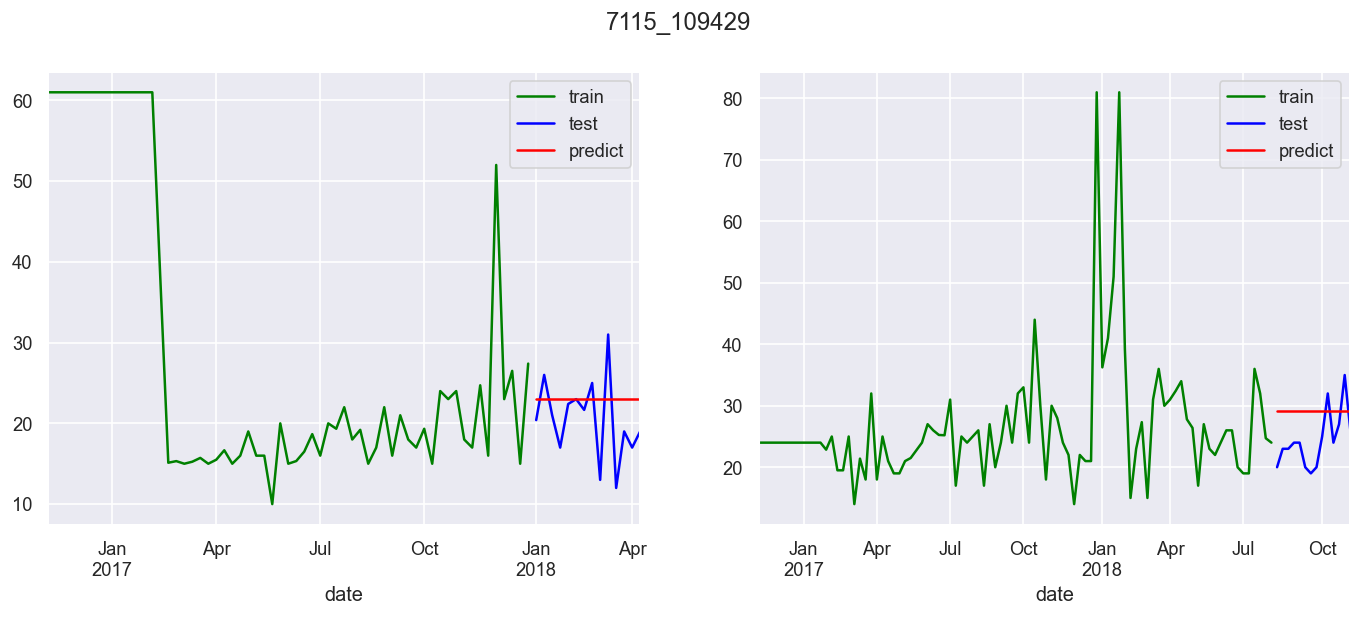

In [147]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))
#for i in range(len(collocs)):
cvset[1][0][random10ts_columns[0]].plot(subplots=True, title=columns4ts[0], ax=axes[0], color='green')
cvset[1][1][random10ts_columns[0]].plot(subplots=True, ax=axes[0], color='blue')
arr = np.array([cvset[1][0][random10ts_columns[0]].iloc[-4:].mean() for i in range(ph)])
pd.DataFrame(data=arr, index=cvset[1][1].index).plot(subplots=True, title=random10ts_columns[0], ax=axes[0], color='red')
axes[0].legend(['train', 'test', 'predict'])

cvset[3][0][random10ts_columns[1]].plot(subplots=True, ax=axes[1], color='green')
cvset[3][1][random10ts_columns[1]].plot(subplots=True,  ax=axes[1], label='test', color='blue')
arr = np.array([cvset[3][0][random10ts_columns[1]].iloc[-4:].mean() for i in range(ph)])
pd.DataFrame(data=arr, index=cvset[3][1].index).plot(subplots=True, title=random10ts_columns[1], ax=axes[1], color='red')
axes[1].legend(['train', 'test', 'predict'])

In [204]:
for col in metrics_mean4last.columns:
    metrics_mean4last.loc[last_index, col] = metrics_mean4last[col].mean()
metrics_mean4last.tail()

,mape1,rmse1,mape2,rmse2,mape3,rmse3,mape4,rmse4,mape5,rmse5
346,0.00601378,0.00948346,0.112569,0.1686,2.20668,3.57818,2.61905,3.50269,3.30952,3.77899
347,0.0203224,0.0321137,0.443448,0.701626,8.81855,10.7699,2.48878,3.29692,2.16003,2.67146
348,0.0265913,0.042065,0.618987,1.00719,10.8692,12.4733,2.33333,2.71387,2.61905,3.04138
349,0.00417931,0.00663717,0.117026,0.206861,3.7629,5.38113,2.9898,3.53801,3.91837,5.53411
350,48.7373,137.063,114.461,118.166,13.7379,15.7824,9.25414,11.9074,39.6353,104.676


## Exponential Smoothing

In [159]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

metrics_es = pd.DataFrame()
expSmForecasts = pd.DataFrame()
for i, col in enumerate(random10ts.columns):
    
    model1 = ExponentialSmoothing(cvset[4][0][col], freq='W', trend='mul', seasonal=None)
    model2 = ExponentialSmoothing(cvset[4][0][col], freq='W', trend="add", damped=True)
    model3 = ExponentialSmoothing(cvset[4][0][col], freq='W', trend="add", seasonal="add", seasonal_periods=52)
    model4 = ExponentialSmoothing(cvset[4][0][col], freq='W', trend="add", seasonal="mul", seasonal_periods=52)
    model5 = ExponentialSmoothing(cvset[4][0][col], freq='W', trend="add", seasonal="mul", seasonal_periods=52, damped=True)
    fit1 = model1.fit()
    pred1 = fit1.forecast(ph)
    metrics_es.loc[i, 'model1'] = mse(pred1, cvset[4][1][col], squared=False)
    expSmForecasts['model1_' + str(i)] = pred1
    fit2 = model2.fit()
    pred2 = fit2.forecast(ph)
    metrics_es.loc[i, 'model2'] = mse(pred2, cvset[4][1][col], squared=False)
    expSmForecasts['model2_' + str(i)] = pred2
    fit3 = model3.fit()
    pred3 = fit3.forecast(ph)
    metrics_es.loc[i, 'model3'] = mse(pred3, cvset[4][1][col], squared=False)
    expSmForecasts['model3_' + str(i)] = pred3
    fit4 = model4.fit()
    pred4 = fit4.forecast(ph)
    metrics_es.loc[i, 'model4'] = mse(pred4, cvset[4][1][col], squared=False)
    expSmForecasts['model4_' + str(i)] = pred4
    fit5 = model5.fit()
    pred5 = fit5.forecast(ph)
    metrics_es.loc[i, 'model5'] = mse(pred5, cvset[4][1][col], squared=False)
    expSmForecasts['model5_' + str(i)] = pred5

metrics_es.mean(axis = 0).idxmin()

/Users/alenalapteva/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/alenalapteva/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/Users/alenalapteva/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/alenalapteva/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/Users/alenalapteva/anaconda3/lib/python3.8/site-packages/statsmod

,model1,model2,model3,model4,model5
0,18.259227,17.844435,22.452611,17.664860,17.802905
1,21.281933,20.917824,15.017597,14.661291,10.459112
2,151.802577,151.965658,117.250484,143.228079,78.665362
3,3.639903,3.436441,12.406234,4.785901,6.737616
4,23.076112,52.832168,18.363194,18.818586,24.834840
5,560.387744,548.405113,235.368742,549.237079,484.786838
6,414.832107,418.068877,411.547401,394.915838,388.436838
7,37.501745,37.107191,18.981620,31.259786,39.110809
8,257.637141,243.809309,88.277820,127.715822,54.112442
9,6.507050,3.355518,11.517490,8.467840,4.629883


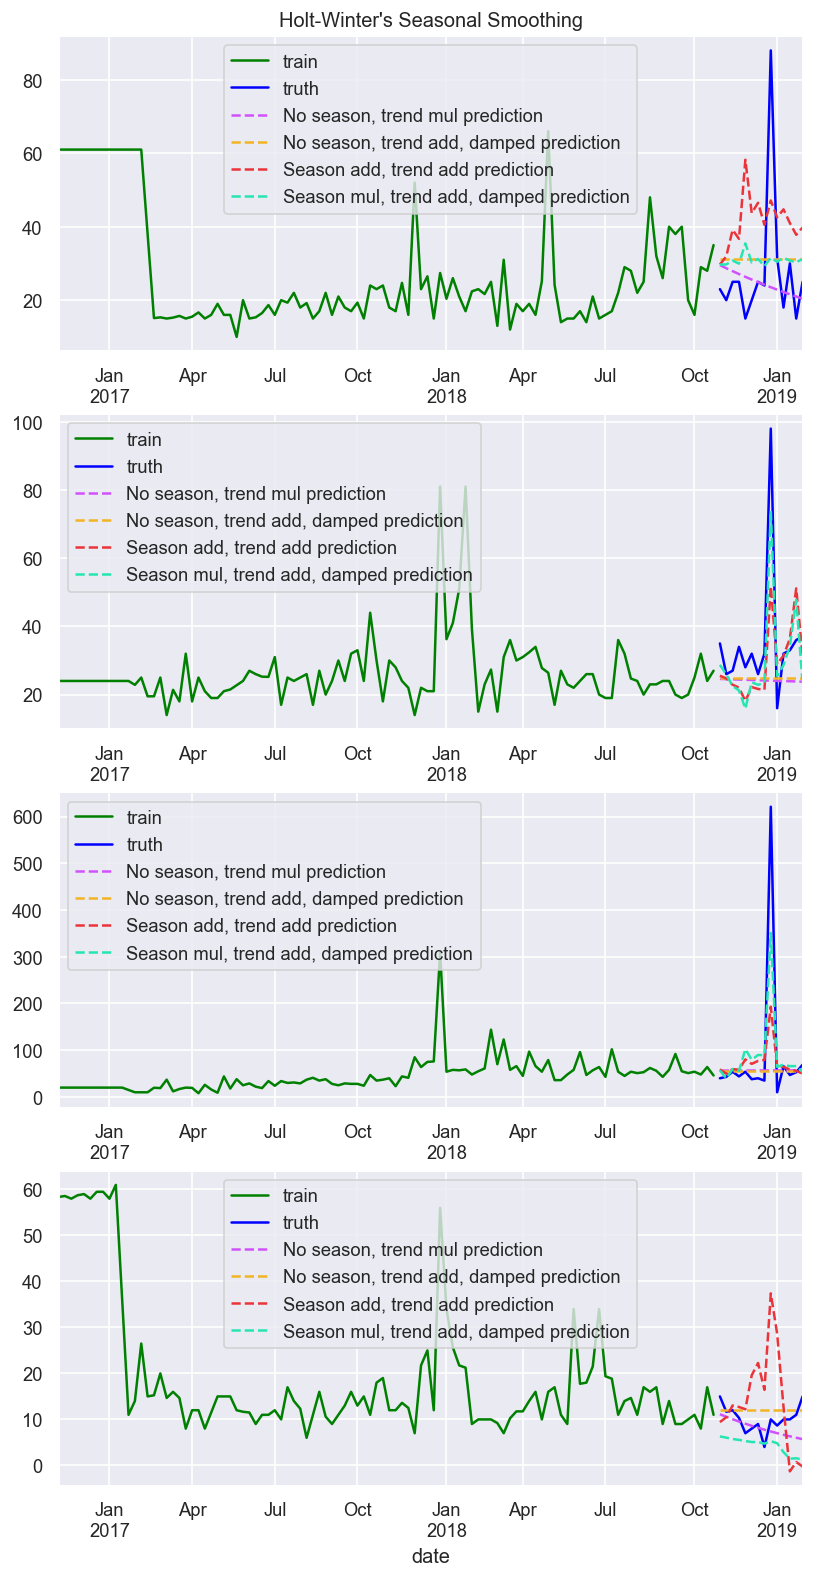

In [158]:
# Plot ExponentialSmoothing

fig, ax4 = plt.subplots(4, 1, figsize=(8,16))
for i, col in enumerate(random10ts_columns[:4]):
    cvset[4][0][random10ts_columns[i]].plot(subplots=True, label='train', ax=ax4[i], color='green')
    cvset[4][1][random10ts_columns[i]].plot(subplots=True, ax=ax4[i], color='blue', label='truth')
    expSmForecasts['model1_' + str(i)].plot(subplots=True, ax=ax4[i], linestyle='--', color='#d151fc', label='No season, trend mul prediction')
    expSmForecasts['model2_' + str(i)].plot(subplots=True, ax=ax4[i], linestyle='--', color='#f2b424', label='No season, trend add, damped prediction')
    expSmForecasts['model3_' + str(i)].plot(subplots=True, ax=ax4[i], linestyle='--', color='#eb343a', label='Season add, trend add prediction')
    expSmForecasts['model5_' + str(i)].plot(subplots=True, ax=ax4[i], linestyle='--', color='#13bd8f', label='Season mul, trend add, damped prediction')
    ax4[i].legend();
ax4[0].set_title("Holt-Winter's Seasonal Smoothing");

In [85]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

with mlflow.start_run(run_name='ExponentialSmoothing'):
    metrics_exp_sm = pd.DataFrame()
    seasonal_periods=52
    for i in range(len(cvset)):
        for j, col in enumerate(cvset[i][0].columns):
            if(i < 4):
                model = ExponentialSmoothing(cvset[i][0][col], freq='W', trend="add", damped=True)
            else:
                model = ExponentialSmoothing(cvset[i][0][col], freq='W', trend="add", seasonal="mul", seasonal_periods=seasonal_periods, damped=True)
            fit = model.fit()
            pred = fit.forecast(ph)
            metrics_exp_sm.loc[j, 'mape' + str(i+1)] = mape(pred, cvset[i][1][col])
            metrics_exp_sm.loc[j, 'rmse' + str(i+1)] = mse(pred, cvset[i][1][col], squared=False)
    
    wrapper = PythonModelWrapper(model)
    mlflow.pyfunc.log_model('ExponentialSmoothing', python_model=wrapper)
    mape_mean, rmse_mean = calc_mean_metrics(metrics_exp_sm)
    mlflow.log_metric("mape", mape_mean)
    mlflow.log_metric("rmse", rmse_mean)

## SMARIMA

Estimate number of differences d and D

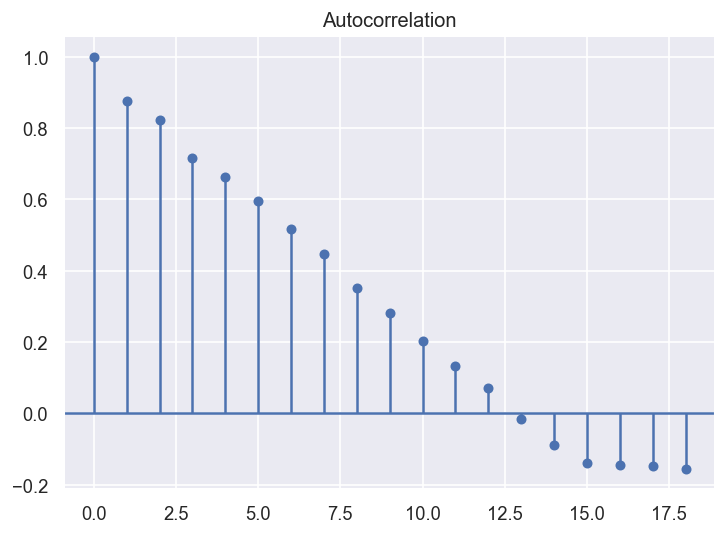

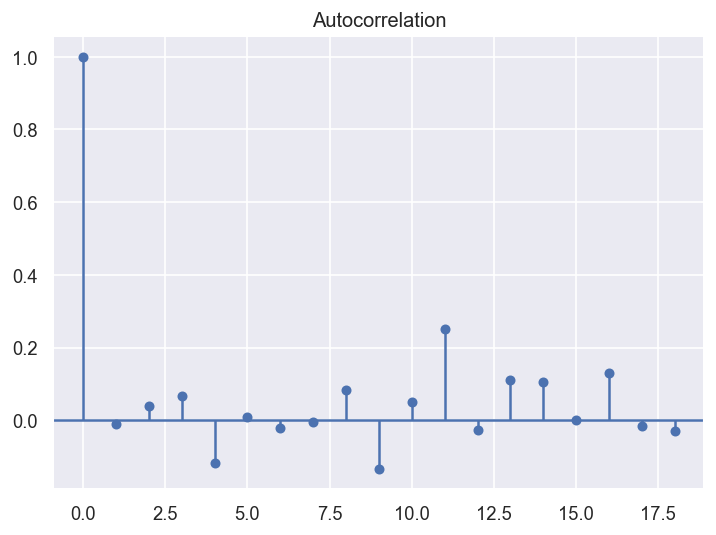

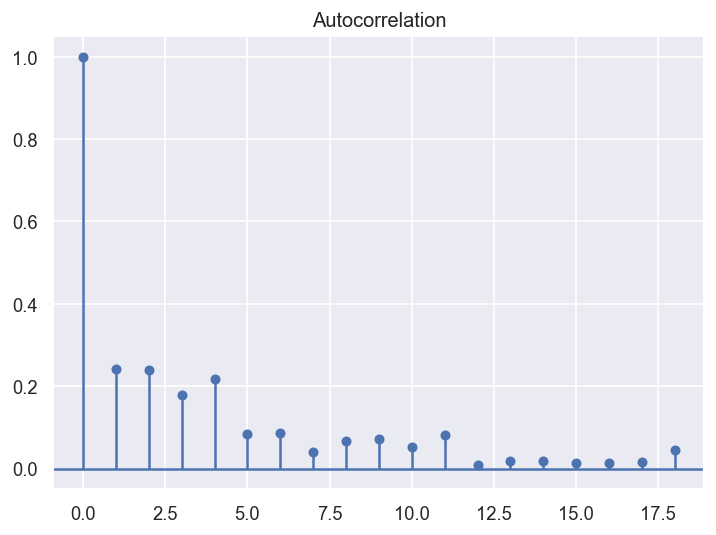

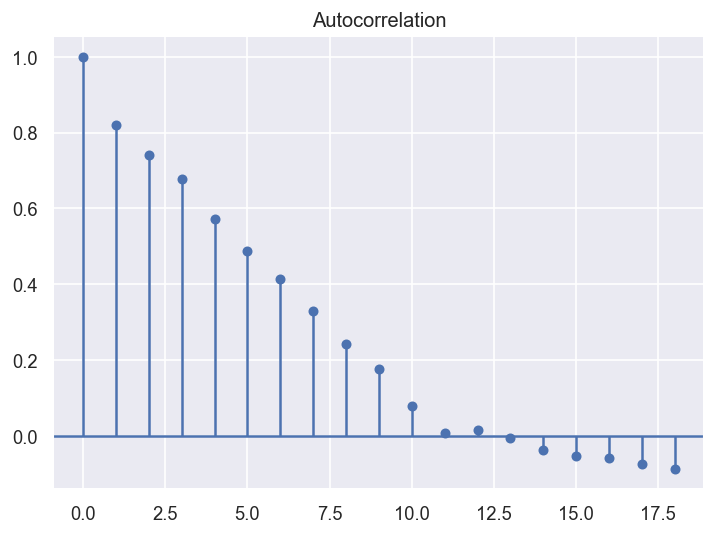

In [13]:
for i, game_code in enumerate(random10ts_columns[5:9]):
    pm.plot_acf(cvset[1][0][random10ts_columns[i]])

Some of TS are auto-correlated (with lags till 8-10), some of them are not.

In [86]:
# Estimate the number of differences using an KPSS test:

def n_diffs_counter(df):
    n_diffs = np.zeros(5)
    for i, col in enumerate(df.columns):
        n_kpss = ndiffs(df[col], test='kpss')
        n_diffs[n_kpss] += 1
    for j, val in enumerate(n_diffs):
        print('{j}_diffs: {v}\n'.format(j=str(j), v=str(val)))

In [87]:
for i in range(len(cvset)):
    print(str(i)+ ' dataset:')
    n_diffs_counter(cvset[i][0])

0 dataset:
0_diffs: 173.0

1_diffs: 177.0

2_diffs: 0.0

3_diffs: 0.0

4_diffs: 0.0

1 dataset:
0_diffs: 209.0

1_diffs: 136.0

2_diffs: 5.0

3_diffs: 0.0

4_diffs: 0.0

2 dataset:
0_diffs: 166.0

1_diffs: 184.0

2_diffs: 0.0

3_diffs: 0.0

4_diffs: 0.0

3 dataset:
0_diffs: 210.0

1_diffs: 139.0

2_diffs: 1.0

3_diffs: 0.0

4_diffs: 0.0

4 dataset:
0_diffs: 223.0

1_diffs: 127.0

2_diffs: 0.0

3_diffs: 0.0

4_diffs: 0.0



In [37]:
# estimate number of seasonal differences using a Canova-Hansen test
from pmdarima.arima.utils import nsdiffs

def n_seaonal_diffs_counter(df):
    n_diffs = np.zeros(5)
    for i, col in enumerate(df.columns):
        D = nsdiffs(df[col],
            m=52,  # Weekly
            max_D=5,
            test='ch') 
        n_diffs[D] += 1
    for j, val in enumerate(n_diffs):
        print('{j}_seasonal_diffs: {v}\n'.format(j=str(j), v=str(val)))

In [38]:
for i in range(len(cvset)):
    print(str(i)+ ' dataset:')
    n_seaonal_diffs_counter(cvset[i][0])

0 dataset:
0_seasonal_diffs: 350.0

1_seasonal_diffs: 0.0

2_seasonal_diffs: 0.0

3_seasonal_diffs: 0.0

4_seasonal_diffs: 0.0

1 dataset:
0_seasonal_diffs: 350.0

1_seasonal_diffs: 0.0

2_seasonal_diffs: 0.0

3_seasonal_diffs: 0.0

4_seasonal_diffs: 0.0

2 dataset:
0_seasonal_diffs: 350.0

1_seasonal_diffs: 0.0

2_seasonal_diffs: 0.0

3_seasonal_diffs: 0.0

4_seasonal_diffs: 0.0

3 dataset:
0_seasonal_diffs: 350.0

1_seasonal_diffs: 0.0

2_seasonal_diffs: 0.0

3_seasonal_diffs: 0.0

4_seasonal_diffs: 0.0

4 dataset:
0_seasonal_diffs: 350.0

1_seasonal_diffs: 0.0

2_seasonal_diffs: 0.0

3_seasonal_diffs: 0.0

4_seasonal_diffs: 0.0



In [40]:
# Several SMARIMAs
import warnings
warnings.filterwarnings("ignore")

d=1
D=0
m=52
metrics_arima = pd.DataFrame()
arima_forecasts = pd.DataFrame()
for i, col in enumerate(random10ts.columns):
    
    model1 = sm.tsa.statespace.SARIMAX(cvset[4][0][col], order=(0, d, 1), seasonal_order=(0, D, 0, m))
    model2 = sm.tsa.statespace.SARIMAX(cvset[4][0][col], order=(4, d, 0), seasonal_order=(0, D, 0, m))
    model3 = sm.tsa.statespace.SARIMAX(cvset[4][0][col], order=(1, d, 1), seasonal_order=(1, D, 1, m))
    model4 = sm.tsa.statespace.SARIMAX(cvset[4][0][col], order=(1, d, 6), seasonal_order=(0, D, 1, m))
    model5 = sm.tsa.statespace.SARIMAX(cvset[4][0][col], order=(6, d, 6), seasonal_order=(0, D, 0, m))
    model6 = sm.tsa.statespace.SARIMAX(cvset[4][0][col], order=(10, d, 6), seasonal_order=(0, D, 0, m))
    model7 = sm.tsa.statespace.SARIMAX(cvset[4][0][col], order=(4, d, 8), seasonal_order=(0, D, 0, m))
    model8 = sm.tsa.statespace.SARIMAX(cvset[4][0][col], order=(12, d, 12), seasonal_order=(0, D, 0, m))
    model9 = sm.tsa.statespace.SARIMAX(cvset[4][0][col], order=(6, d, 6), seasonal_order=(2, D, 2, m))
    fit1 = model1.fit()
    pred1 = fit1.forecast(ph)
    metrics_arima.loc[i, 'model1'] = mse(pred1, cvset[4][1][col], squared=False)
    arima_forecasts['model1_' + str(i)] = pred1
    fit2 = model2.fit()
    pred2 = fit2.forecast(ph)
    metrics_arima.loc[i, 'model2'] = mse(pred2, cvset[4][1][col], squared=False)
    arima_forecasts['model2_' + str(i)] = pred2
    fit3 = model3.fit()
    pred3 = fit3.forecast(ph)
    metrics_arima.loc[i, 'model3'] = mse(pred3, cvset[4][1][col], squared=False)
    arima_forecasts['model3_' + str(i)] = pred3
    fit4 = model4.fit()
    pred4 = fit4.forecast(ph)
    metrics_arima.loc[i, 'model4'] = mse(pred4, cvset[4][1][col], squared=False)
    arima_forecasts['model4_' + str(i)] = pred4
    fit5 = model5.fit()
    pred5 = fit5.forecast(ph)
    metrics_arima.loc[i, 'model5'] = mse(pred5, cvset[4][1][col], squared=False)
    arima_forecasts['model5_' + str(i)] = pred5
    fit6 = model6.fit()
    pred6 = fit6.forecast(ph)
    metrics_arima.loc[i, 'model6'] = mse(pred6, cvset[4][1][col], squared=False)
    arima_forecasts['model6_' + str(i)] = pred6
    fit7 = model7.fit()
    pred7 = fit7.forecast(ph)
    metrics_arima.loc[i, 'model7'] = mse(pred7, cvset[4][1][col], squared=False)
    arima_forecasts['model7_' + str(i)] = pred7
    fit8 = model8.fit()
    pred8 = fit8.forecast(ph)
    metrics_arima.loc[i, 'model8'] = mse(pred8, cvset[4][1][col], squared=False)
    arima_forecasts['model8_' + str(i)] = pred8
    fit9 = model9.fit()
    pred9 = fit9.forecast(ph)
    metrics_arima.loc[i, 'model9'] = mse(pred9, cvset[4][1][col], squared=False)
    arima_forecasts['model9_' + str(i)] = pred9

metrics_arima

,model1,model2,model3,model4,model5,model6,model7,model8,model9
0,17.854421,17.623242,17.817703,17.713498,18.644874,18.647749,18.616449,18.786415,18.759138
1,20.808620,19.818953,19.604597,19.326089,20.209175,21.009321,20.298780,20.236563,19.904727
2,151.996320,152.684577,153.323708,152.967836,152.292258,152.726991,151.175415,151.908051,156.493409
3,3.435561,3.569825,4.164401,4.326327,3.287281,3.919575,3.166360,3.025012,13.922966
4,24.012041,24.516356,23.719619,25.699014,27.715669,28.142059,29.622249,40.041868,27.013673
5,549.085813,545.989740,506.976893,526.169485,543.787363,547.001618,548.080468,544.743554,512.722167
6,416.404709,414.969043,401.994168,398.510907,415.583424,414.730525,416.201307,417.121453,371.045125
7,37.178631,38.758828,40.657988,39.460672,38.622841,38.429050,37.794972,40.090643,41.006531
8,249.240639,245.654001,220.459500,220.467735,246.947604,249.213519,249.516096,250.872430,225.772826
9,3.357700,3.330528,2.663407,2.522686,2.954910,2.953121,2.877600,3.121750,3.311129


In [77]:
metrics_arima.mean(axis = 0).idxmin()

'model3'

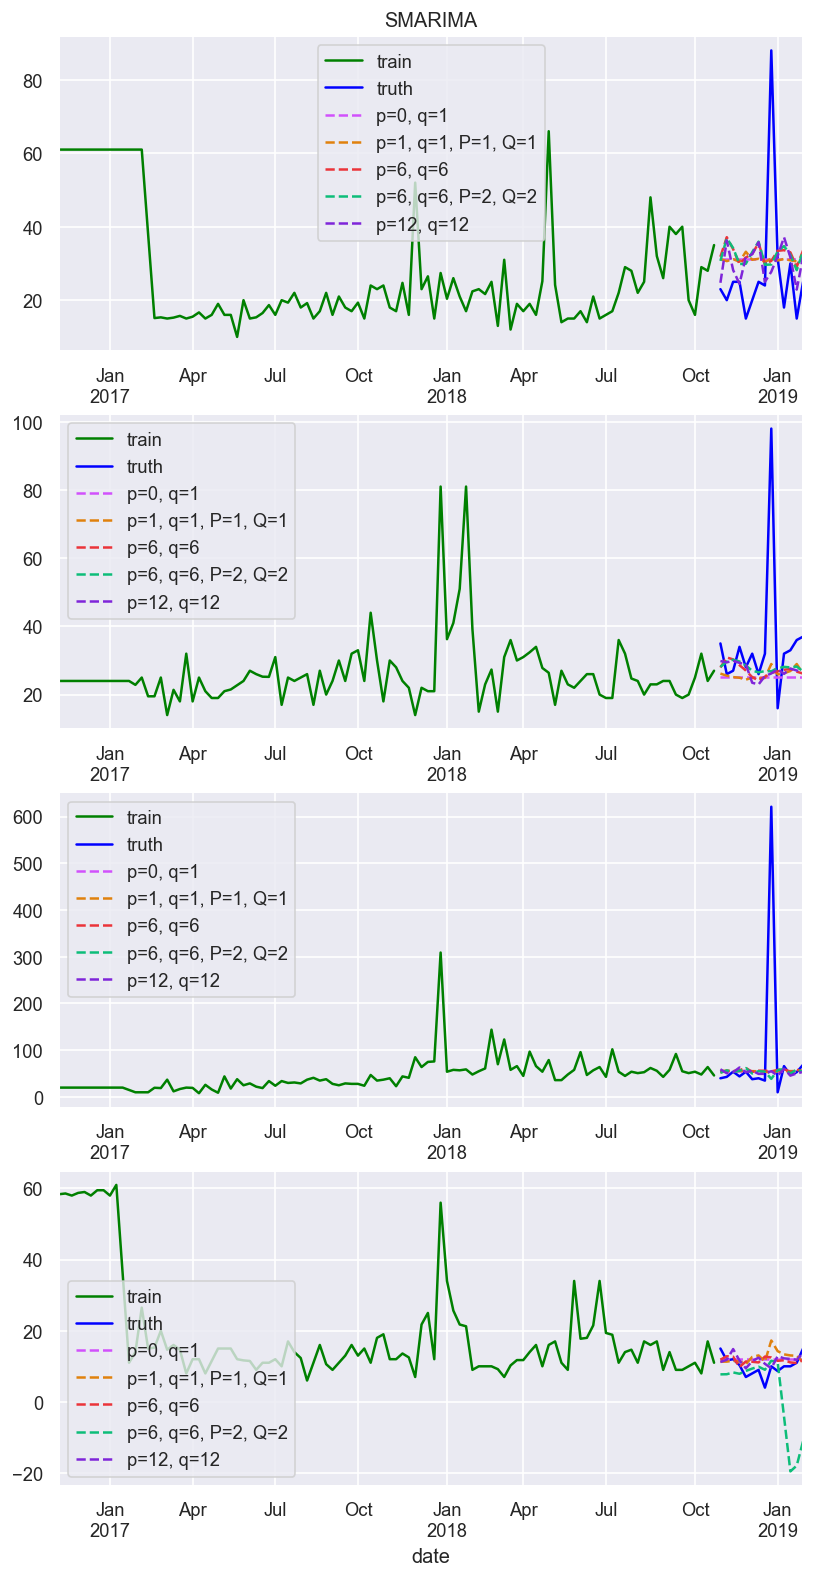

In [47]:
# Plot SMARIMA models

fig, ax4 = plt.subplots(4, 1, figsize=(8,16))
for i, col in enumerate(random10ts_columns[:4]):
    cvset[4][0][random10ts_columns[i]].plot(subplots=True, label='train', ax=ax4[i], color='green')
    cvset[4][1][random10ts_columns[i]].plot(subplots=True, ax=ax4[i], color='blue', label='truth')
    arima_forecasts['model1_' + str(i)].plot(subplots=True, ax=ax4[i], linestyle='--', color='#d151fc', label='p=0, q=1')
    arima_forecasts['model3_' + str(i)].plot(subplots=True, ax=ax4[i], linestyle='--', color='#e0810d', label='p=1, q=1, P=1, Q=1')
    arima_forecasts['model5_' + str(i)].plot(subplots=True, ax=ax4[i], linestyle='--', color='#eb343a', label='p=6, q=6')
    arima_forecasts['model9_' + str(i)].plot(subplots=True, ax=ax4[i], linestyle='--', color='#0dbd79', label='p=6, q=6, P=2, Q=2')
    arima_forecasts['model8_' + str(i)].plot(subplots=True, ax=ax4[i], linestyle='--', color='#7f25d9', label='p=12, q=12')
    ax4[i].legend();
ax4[0].set_title("SMARIMA");

In [55]:
# Auto_arima

d=1
D=0
m=52

for i, col in enumerate(random10ts.columns):
    model1 = pm.auto_arima(cvset[4][1][col], start_p=1, start_q=1,
                             max_p=7, max_q=7, m=m,
                             start_P=0, seasonal=True,
                             d=d, D=D,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
    print(model1.summary())

/Users/alenalapteva/anaconda3/envs/alapteva-time-series/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   14
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -60.296
Date:                Wed, 21 Oct 2020   AIC                            122.592
Time:                        20:13:28   BIC                            123.157
Sample:                             0   HQIC                           122.476
                                 - 14                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       625.4310    166.566      3.755      0.000     298.967     951.894
Ljung-Box (Q):                        6.89   Jarque-Bera (JB):                 3.22
Prob(Q):                              0.86   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   14
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -104.502
Date:                Wed, 21 Oct 2020   AIC                            211.005
Time:                        20:13:50   BIC                            211.570
Sample:                             0   HQIC                           210.889
                                 - 14                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.592e+05   1.31e+05      4.282      0.000    3.03e+05    8.15e+05
Ljung-Box (Q):                        3.14   Jarque-Bera (JB):                 7.82
Prob(Q):                              0.99   Pr

Best model of auto-arima most times is SARIMAX(0, 1, 0)

In [69]:
# Let's train SARIMAX with best parameters we tried

import warnings
warnings.filterwarnings("ignore")

with mlflow.start_run(run_name='SMARIMA'):
    d=1
    D=0
    m=52
    metrics_best_arima = pd.DataFrame()
    seasonal_periods=52
    for i in range(len(cvset)):
        for j, col in enumerate(cvset[i][0].columns):
            model = sm.tsa.statespace.SARIMAX(cvset[4][0][col], order=(1, d, 1), seasonal_order=(1, D, 1, m))
            try:
                fit = model.fit()
                pred = fit.forecast(ph)
                metrics_best_arima.loc[j, 'mape' + str(i+1)] = mape(pred, cvset[i][1][col])
                metrics_best_arima.loc[j, 'rmse' + str(i+1)] = mse(pred, cvset[i][1][col], squared=False)
            except LinAlgError:
                print('LinAlgError: LU decomposition error')
                continue
    
    wrapper = PythonModelWrapper(model)
    mlflow.pyfunc.log_model('SARIMAX', python_model=wrapper)
    mape_mean, rmse_mean = calc_mean_metrics(metrics_best_arima)
    mlflow.log_metric("mape", mape_mean)
    mlflow.log_metric("rmse", rmse_mean)

SMARIMA shows the best result. It's error metrics less then baseline (mean by all TS). ExponentialSmoothing appears to be the worst.